<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## LSTM Traductor
Ejemplo basado en [LINK](https://stackabuse.com/python-for-nlp-neural-machine-translation-with-seq2seq-in-keras/)

### Consignas
Replicar y extender el traductor:
- Replicar el modelo en PyTorch.
- Extender el entrenamiento a más datos y tamaños de
secuencias mayores.
- Explorar el impacto de la cantidad de neuronas en
las capas recurrentes.
- Mostrar 5 ejemplos de traducciones generadas.
- Extras que se pueden probar: Embeddings
pre-entrenados para los dos idiomas; cambiar la
estrategia de generación (por ejemplo muestreo
aleatorio);

### Datos
El objetivo es utilizar datos disponibles del Tatoeba Project de traducciones de texto en diferentes idiomas.  
Se construirá un modelo traductor de inglés a español seq2seq utilizando encoder-decoder.  
[LINK](https://www.manythings.org/anki/)

In [1]:
import requests
import os
from zipfile import ZipFile
import numpy as np

In [2]:
# Funcion auxiliar para descargar el dataset
def download_dataset(dataset_url: str, target_dir: str, check_dir: str | None = None, force: bool = False, tmp_file: str = "tmp.zip", unzip: bool = True):

    if check_dir and os.path.isdir(check_dir) and not force:
        print("Check folder already exists, nothing downloaded.")
        return

    try:
        with requests.get(dataset_url, stream=True, allow_redirects=True) as response:
            response.raise_for_status()  # Raise an exception for bad status codes

            with open(tmp_file, 'wb') as f:
                for chunk in response.iter_content(chunk_size=8192):
                    f.write(chunk)
        print(f"File '{tmp_file}' downloaded successfully.")
    except requests.exceptions.RequestException as e:
        if (os.path.isfile(tmp_file)):
            os.remove(tmp_file)
        raise(Exception(f"Error downloading file: {e}"))

    if not unzip:
        return
    try:
        with ZipFile(tmp_file, 'r') as zip_object:
            zip_object.extractall(target_dir)
        print(f"Successfully extracted '{tmp_file}' to '{target_dir}'.")

    except FileNotFoundError:
        raise(Exception(f"Error: The file '{tmp_file}' was not found."))
    except Exception as e:
        raise(Exception(f"An error occurred: {e}"))
    finally:
        if (os.path.isfile(tmp_file)):
            os.remove(tmp_file)


In [3]:
dataset_url = "http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip"
base_dir = "./"
folder_dir = "spa-eng"
download_dataset(dataset_url, base_dir, check_dir=folder_dir, tmp_file="spa-eng.zip")

Check folder already exists, nothing downloaded.


In [4]:
# Por una cuestion de que no explote la RAM se limitará el tamaño de las sentencias de entrada y salida
max_input_len = 16
max_out_len = 18

In [5]:
# dataset_file

text_file = os.path.join(base_dir, folder_dir, "spa.txt")
with open(text_file, encoding="utf8") as f:
    lines = f.read().split("\n")[:-1]

# Mezclar el dataset, forzar semilla siempre igual
np.random.seed([40])
np.random.shuffle(lines)

input_sentences = []
output_sentences = []
output_sentences_inputs = []
count = 0

for line in lines:
    # el tabulador señaliza la separación entre las oraciones 
    # en ambos idiomas
    if '\t' not in line: 
        continue

    # Input sentence --> eng
    # output --> spa
    input_sentence, output = line.rstrip().split('\t')

    # Limito las longitudes de sentencias
    if (len(input_sentence.split(" ")) > max_input_len) \
        or (len(output.split(" ")) > max_out_len):
        continue

    # output sentence (decoder_output) tiene <eos>
    output_sentence = output + ' <eos>'
    # output sentence input (decoder_input) tiene <sos>
    output_sentence_input = '<sos> ' + output

    input_sentences.append(input_sentence)
    output_sentences.append(output_sentence)
    output_sentences_inputs.append(output_sentence_input)

print("Cantidad de rows disponibles:", len(lines))
print("Cantidad de rows utilizadas:", len(input_sentences))

Cantidad de rows disponibles: 118964
Cantidad de rows utilizadas: 118472


In [6]:
import random
# Solo me quedo con una fracción de textos
# Por limitaciones de RAM
MAX_NUM_SENTENCES = 6000

# random.seed(42)
# rnd_idx = random.sample(range(len(input_sentences)), MAX_NUM_SENTENCES) # Al azar
rnd_idx = range(min(MAX_NUM_SENTENCES, len(input_sentences))) # Primeros n
input_sentences = [input_sentences[i] for i in rnd_idx]
output_sentences = [output_sentences[i] for i in rnd_idx]
output_sentences_inputs = [output_sentences_inputs[i] for i in rnd_idx]

In [7]:
input_sentences[0], output_sentences[0], output_sentences_inputs[0], len(input_sentences)

('A deal is a deal.',
 'Un trato es un trato. <eos>',
 '<sos> Un trato es un trato.',
 6000)

### 2 - Preprocesamiento

In [8]:
from collections import Counter
# Tokenizar las palabras, similar a Tokenizer de Keras
class Tokenizer():
    def __init__(self, num_words: int | None = None, filters: str = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'):
        self.num_words = num_words
        self.filters = filters
        self.word_index = {}

    def __preprocess_text(self, text: str) -> list[str]:
        # Quito caracteres especiales y paso todo a minusculas
        text = ''.join(' ' if char in self.filters else char for char in text.lower())
        return [word for word in text.split(' ') if word]

    def fit_on_texts(self, input_sentences: list[str], force_include: list[str] = []) -> None:
        if (len(self.word_index) != 0):
            raise(Exception("Tokenizer has already been fit."))
        # Guardo cantidad de apariciones de cada palabra
        counter = Counter()
        for text in input_sentences:
            sentence = self.__preprocess_text(text)
            if not sentence: continue
            counter.update(sentence)

        # Selecciono las más comunes, si es que se indica máximo
        most_common_n_words = counter.most_common(self.num_words)
        # Fuerzo la inclusion de ciertas palabras
        # ya que podrían quedar fuera por no se tan comunes
        # (pasa con <eos> ya que se fittea con las frases que no lo contienen)
        for forced in reversed(force_include):
            if forced not in tuple(zip(*most_common_n_words))[0]:
                most_common_n_words.insert(0, (forced, 0))
        # Si se insertó alguna palabra forzada tengo que volver
        # a quedarme con las N mas comunes (o todas si no se indica)
        most_common_n_words = most_common_n_words[:self.num_words]
        # Calculamos indices para cada palabra, empezando en 1 (igual que Keras)
        self.word_index = { word: i+1 for i, (word, _) in enumerate(most_common_n_words)}

    def texts_to_sequences(self, input_sentences: list[str]):
        if (len(self.word_index) == 0):
            raise(Exception("Tokenizer has not been fit yet."))
        input_integer_seq = []
        for tokens in input_sentences:
            tokens = self.__preprocess_text(tokens)
            if not tokens: continue
            sequence = [self.word_index[word] for word in tokens if word in self.word_index]
            input_integer_seq.append(sequence)
        return input_integer_seq

In [9]:
# Definir el tamaño máximo del vocabulario
MAX_VOCAB_SIZE = 8000
# Vamos a necesitar un tokenizador para cada idioma

In [10]:
# tokenizador de inglés
input_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
input_tokenizer.fit_on_texts(input_sentences)
input_integer_seq = input_tokenizer.texts_to_sequences(input_sentences)

word2idx_inputs = input_tokenizer.word_index
print("Palabras en el vocabulario:", len(word2idx_inputs))

max_input_len = max(len(sen) for sen in input_integer_seq)
print("Sentencia de entrada más larga:", max_input_len)

Palabras en el vocabulario: 3826
Sentencia de entrada más larga: 16


In [11]:
word2idx_inputs

{'the': 1,
 'to': 2,
 'i': 3,
 'you': 4,
 'tom': 5,
 'a': 6,
 'is': 7,
 'he': 8,
 'in': 9,
 'of': 10,
 'that': 11,
 'do': 12,
 'was': 13,
 'it': 14,
 'me': 15,
 'my': 16,
 'this': 17,
 'have': 18,
 'she': 19,
 'for': 20,
 'what': 21,
 'are': 22,
 "don't": 23,
 'his': 24,
 'mary': 25,
 'on': 26,
 'we': 27,
 'be': 28,
 'with': 29,
 'your': 30,
 'want': 31,
 'not': 32,
 'and': 33,
 "i'm": 34,
 'at': 35,
 'know': 36,
 'like': 37,
 'him': 38,
 'go': 39,
 'time': 40,
 'her': 41,
 'has': 42,
 'can': 43,
 'will': 44,
 'all': 45,
 'how': 46,
 'about': 47,
 'very': 48,
 'did': 49,
 'here': 50,
 'there': 51,
 "it's": 52,
 'as': 53,
 'up': 54,
 'think': 55,
 "didn't": 56,
 'they': 57,
 'when': 58,
 'had': 59,
 "can't": 60,
 'were': 61,
 'no': 62,
 'from': 63,
 'come': 64,
 'if': 65,
 'get': 66,
 'see': 67,
 'good': 68,
 'why': 69,
 "doesn't": 70,
 'been': 71,
 'an': 72,
 'by': 73,
 'out': 74,
 'please': 75,
 'just': 76,
 'tell': 77,
 'would': 78,
 'home': 79,
 'going': 80,
 'much': 81,
 'than': 82

In [12]:
# tokenizador de español
# A los filtros de símbolos del Tokenizer agregamos el "¿",
# sacamos los "<>" para que no afectar nuestros tokens
output_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='!"#$%&()*+,-./:;=¿?@[\\]^_`{|}~\t\n')
output_tokenizer.fit_on_texts(output_sentences, force_include=["<sos>", "<eos>"])
output_integer_seq = output_tokenizer.texts_to_sequences(output_sentences)
output_input_integer_seq = output_tokenizer.texts_to_sequences(output_sentences_inputs)

word2idx_outputs = output_tokenizer.word_index
print("Palabras en el vocabulario:", len(word2idx_outputs))

# Se suma 1 para incluir el token de palabra desconocida
# El tokenizador reserva el índice 0 para esto, hay que contemplarlo
num_words_output = min(len(word2idx_outputs), MAX_VOCAB_SIZE) + 1

max_out_len = max(len(sen) for sen in output_integer_seq)
print("Sentencia de salida más larga:", max_out_len)

Palabras en el vocabulario: 5687
Sentencia de salida más larga: 19


In [13]:
print(f"Sentencia de entrada más larga: {max_input_len}.")
print(f"Sentencia de salida más larga: {max_out_len}.")

Sentencia de entrada más larga: 16.
Sentencia de salida más larga: 19.


In [14]:
for sec in output_tokenizer.texts_to_sequences(["<sos>", "<eos>"]):
    assert sec, "El tokenizador debe incluir <sos> y <eos>"

A la hora de realizar padding es importante tener en cuenta que en el encoder los ceros se agregan al comienzo y en el decoder al final.  
Esto es porque la salida del encoder está basado en las últimas palabras de la sentencia (son las más importantes), mientras que en el decoder está basado en el comienzo de la secuencia de salida ya que es la realimentación del sistema y termina con fin de sentencia.

In [15]:
def pad_sequences(sequences, maxlen=None, dtype='int32', padding_pre=True, value=0.0):
    if maxlen is None:
        maxlen = max(len(s) for s in sequences)

    out_secuences = []
    for secuence in sequences:
        if len(secuence) < maxlen: # Hago padding hasta max_len
            if padding_pre:
                sec_out = [value] * (maxlen - len(secuence)) + secuence
            else:
                sec_out = secuence + [value] * (maxlen - len(secuence))
        else: # O me quedo con los max_len caracteres
            if padding_pre:
                sec_out = secuence[-maxlen:]
            else:
                sec_out = secuence[:maxlen]
        out_secuences.append(sec_out)

    return np.array(out_secuences, dtype=dtype)

In [16]:
print("Cantidad de rows del dataset:", len(input_integer_seq))

encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len)
print("encoder_input_sequences shape:", encoder_input_sequences.shape)

decoder_input_sequences = pad_sequences(output_input_integer_seq, maxlen=max_out_len, padding_pre=False)
print("decoder_input_sequences shape:", decoder_input_sequences.shape)

Cantidad de rows del dataset: 6000
encoder_input_sequences shape: (6000, 16)
decoder_input_sequences shape: (6000, 19)


In [17]:
encoder_input_sequences[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   6, 684,
         7,   6, 684], dtype=int32)

In [18]:
decoder_input_sequences[0]

array([  1,  12, 933,  10,  12, 933,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0], dtype=int32)

In [19]:
decoder_output_sequences = pad_sequences(output_integer_seq, maxlen=max_out_len, padding_pre=False)
decoder_targets = decoder_output_sequences
decoder_targets.shape

(6000, 19)

In [20]:
decoder_output_sequences[0]

array([ 12, 933,  10,  12, 933,   2,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0], dtype=int32)

### 3 - Preparar los embeddings

In [21]:
url = 'https://drive.usercontent.google.com/download?id=1KY6avD5I1eI2dxQzMkR3WExwKwRq2g94&export=download&confirm=t&uuid=07c897f9-d9a1-4bdd-8cce-70c9dca2368a&at=AKSUxGMQs76z20Q73h7ULNM9qfje%3A1759553933720'
output = 'gloveembedding.pkl'
if os.access(os.path.join(base_dir, output), os.F_OK) is False:
    download_dataset(url, base_dir, tmp_file=output, unzip=False)
else:
    print("Los embeddings gloveembedding.pkl ya están descargados")

Los embeddings gloveembedding.pkl ya están descargados


In [22]:
import logging
import os
from pathlib import Path
import pickle

class WordsEmbeddings(object):
    logger = logging.getLogger(__name__)

    def __init__(self):
        # load the embeddings
        words_embedding_pkl = Path(self.PKL_PATH)
        if not words_embedding_pkl.is_file():
            words_embedding_txt = Path(self.WORD_TO_VEC_MODEL_TXT_PATH)
            assert words_embedding_txt.is_file(), 'Words embedding not available'
            embeddings = self.convert_model_to_pickle()
        else:
            embeddings = self.load_model_from_pickle()
        self.embeddings = embeddings
        # build the vocabulary hashmap
        index = np.arange(self.embeddings.shape[0])
        # Dicctionarios para traducir de embedding a IDX de la palabra
        self.word2idx = dict(zip(self.embeddings['word'], index))
        self.idx2word = dict(zip(index, self.embeddings['word']))

    def get_words_embeddings(self, words):
        words_idxs = self.words2idxs(words)
        return self.embeddings[words_idxs]['embedding']

    def words2idxs(self, words):
        return np.array([self.word2idx.get(word, -1) for word in words])

    def idxs2words(self, idxs):
        return np.array([self.idx2word.get(idx, '-1') for idx in idxs])

    def load_model_from_pickle(self):
        self.logger.debug(
            'loading words embeddings from pickle {}'.format(
                self.PKL_PATH
            )
        )
        max_bytes = 2**28 - 1 # 256MB
        bytes_in = bytearray(0)
        input_size = os.path.getsize(self.PKL_PATH)
        with open(self.PKL_PATH, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
        embeddings = pickle.loads(bytes_in)
        self.logger.debug('words embeddings loaded')
        return embeddings

    def convert_model_to_pickle(self):
        # create a numpy strctured array:
        # word     embedding
        # U50      np.float32[]
        # word_1   a, b, c
        # word_2   d, e, f
        # ...
        # word_n   g, h, i
        self.logger.debug(
            'converting and loading words embeddings from text file {}'.format(
                self.WORD_TO_VEC_MODEL_TXT_PATH
            )
        )
        structure = [('word', np.dtype('U' + str(self.WORD_MAX_SIZE))),
                     ('embedding', np.float32, (self.N_FEATURES,))]
        structure = np.dtype(structure)
        # load numpy array from disk using a generator
        with open(self.WORD_TO_VEC_MODEL_TXT_PATH, encoding="utf8") as words_embeddings_txt:
            embeddings_gen = (
                (line.split()[0], line.split()[1:]) for line in words_embeddings_txt
                if len(line.split()[1:]) == self.N_FEATURES
            )
            embeddings = np.fromiter(embeddings_gen, structure)
        # add a null embedding
        null_embedding = np.array(
            [('null_embedding', np.zeros((self.N_FEATURES,), dtype=np.float32))],
            dtype=structure
        )
        embeddings = np.concatenate([embeddings, null_embedding])
        # dump numpy array to disk using pickle
        max_bytes = 2**28 - 1 # # 256MB
        bytes_out = pickle.dumps(embeddings, protocol=pickle.HIGHEST_PROTOCOL)
        with open(self.PKL_PATH, 'wb') as f_out:
            for idx in range(0, len(bytes_out), max_bytes):
                f_out.write(bytes_out[idx:idx+max_bytes])
        self.logger.debug('words embeddings loaded')
        return embeddings


class GloveEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'glove.twitter.27B.50d.txt'
    PKL_PATH = 'gloveembedding.pkl'
    N_FEATURES = 50
    WORD_MAX_SIZE = 60

class FasttextEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'cc.en.300.vec'
    PKL_PATH = 'fasttext.pkl'
    N_FEATURES = 300
    WORD_MAX_SIZE = 60

In [23]:
# Por una cuestion de RAM se utilizarán los embeddings de Glove de dimension 50
model_embeddings = GloveEmbeddings()

In [24]:
# Crear la Embedding matrix de las secuencias
# en inglés

print('preparing embedding matrix...')
embed_dim = model_embeddings.N_FEATURES
words_not_found = []

# word_index proviene del tokenizer
# Se suma 1 para incluir el token de palabra desconocida
# El tokenizador reserva el índice 0 para esto, hay que contemplarlo
nb_words = min(MAX_VOCAB_SIZE, len(word2idx_inputs)) + 1 # vocab_size
embedding_matrix = np.zeros((nb_words, embed_dim))
for word, i in word2idx_inputs.items():
    if i >= nb_words:
        break
    embedding_vector = model_embeddings.get_words_embeddings([word])[0]
    if (embedding_vector is not None) and sum(embedding_vector) != 0:
        embedding_matrix[i] = embedding_vector
    else:
        # words not found in embedding index will be all-zeros.
        words_not_found.append(word)

print('number of null word embeddings:', np.sum(np.sum(embedding_matrix**2, axis=1) == 0))
print(words_not_found)

preparing embedding matrix...
number of null word embeddings: 142
["don't", "i'm", "it's", "didn't", "can't", "doesn't", "you're", "i'll", "i've", "isn't", "he's", "let's", "tom's", "we're", "i'd", "that's", "what's", "there's", "won't", "she's", "mary's", "you'll", "couldn't", "aren't", "wasn't", "they're", "we'll", "you've", "wouldn't", '30', "hasn't", '2', "haven't", "we've", "who's", "where's", "he'll", "it'll", "shouldn't", "he'd", "you'd", "hadn't", '10', "must've", "they'll", '8', "should've", "driver's", "how's", "man's", "something's", '000', "today's", "father's", "weren't", '25th', "what're", "friend's", "this'll", "they'd", '3', '00', "what'll", "john's", "everyone's", "mother's", "they've", "she'll", '20', "car's", '15', "someone's", "husband's", "'small'", "'little'", "life's", "actress's", "robber's", "bread's", "wife's", "temperature's", "japan's", '22', "name's", "everybody's", '500', "eagle's", 'shiegal', 'marriageable', "it'd", "could've", "who'll", 'elegible', '13',

In [25]:
# Dimensión de los embeddings de la secuencia en inglés
embedding_matrix.shape

(3827, 50)

### 4 - Entrenar el modelo

In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Encoder(nn.Module):
    def __init__(self, embedding_matrix, dropout = 0.2, lstm_size = 128, num_layers = 1):
        super().__init__()
        self.lstm_size = lstm_size
        self.num_layers = num_layers
        self.embedding_dim = embedding_matrix.shape[1]
        
        # El tamaño del embedding lo toma directamente de la matriz que se creó antes
        self.embedding = nn.Embedding.from_pretrained(torch.from_numpy(embedding_matrix).float(), freeze=False, padding_idx=0)
        self.lstm = nn.LSTM(input_size=self.embedding_dim, hidden_size=self.lstm_size, batch_first=True,
                            num_layers=self.num_layers, dropout=dropout) # LSTM layer
        # Agrego dropout para mejorar el entrenamiento
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = self.dropout(self.embedding(x))
        _, (ht, ct) = self.lstm(out) # Del encoder solo se usa h y c
        return (ht, ct)

class Decoder(nn.Module):
    def __init__(self, vocab_size, output_dim, embed_dim, dropout = 0.2, lstm_size = 128, num_layers = 1):
        super().__init__()
        # num_embeddings = vocab_size, definido por el Tokenizador
        # embedding_dim = 50 --> dimensión de los embeddings utilizados
        self.lstm_size = lstm_size
        self.num_layers = num_layers
        self.embedding_dim = embed_dim
        self.output_dim = output_dim

        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=self.embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(input_size=self.embedding_dim, hidden_size=self.lstm_size, batch_first=True,
                            num_layers=self.num_layers, dropout=dropout) # LSTM layer
        self.fc1 = nn.Linear(in_features=self.lstm_size, out_features=self.output_dim) # Fully connected layer
        # Agrego dropout para mejorar el entrenamiento
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, prev_state):
        out = self.dropout(self.embedding(x))
        lstm_output, (ht, ct) = self.lstm(out, prev_state)
        # Con softmax no funciona, la salida pura si
        # out = self.softmax(self.fc1(lstm_output[:,-1,:])) # take last output (last seq)
        # Sospecho que es porque en CrossEntropyLoss fue necesario (ignore_index=0)
        # y con softmax estamos modificando el 0
        out = self.fc1(lstm_output[:,-1,:])
        return out, (ht, ct)

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

        assert encoder.lstm_size == decoder.lstm_size, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.num_layers == decoder.num_layers, \
            "Encoder and decoder must have equal number of layers!"
        
    def forward(self, encoder_input, decoder_input, teacher_forcing_ratio):
        batch_size = decoder_input.shape[0]
        decoder_input_len = decoder_input.shape[1]
        vocab_size = self.decoder.output_dim
        # tensor para almacenar la salida
        # (batch_size, sentence_len, vocab_size)
        outputs = torch.zeros(batch_size, decoder_input_len, vocab_size).to(self.device)
            
        # ultimo hidden state del encoder, primer estado oculto del decoder
        prev_state = self.encoder(encoder_input)
        # En la primera iteracion se toma el primer token de target (<sos>)
        input = decoder_input[:, 0:1]

        for t in range(1, decoder_input_len):
            # t --> token index

            # ingresar cada token embedding, uno por uno junto al hidden state
            # recibir el output del decoder
            output, prev_state = self.decoder(input, prev_state)

            # guardar cada salida
            outputs[:, t, :] = output

            # decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            # get the highest predicted token from our predictions
            top1 = output.argmax(1, keepdim=True)
            # if teacher forcing, use actual next token as next input
            # if not, use predicted token
            input = decoder_input[:, t:t+1] if teacher_force else top1

        return outputs

In [27]:
encoder = Encoder(embedding_matrix, dropout=0)
print(encoder)

# decoder --> vocab_size == output_dim --> porque recibe y devuelve palabras en el mismo vocabulario
decoder = Decoder(vocab_size=num_words_output, output_dim=num_words_output, embed_dim=embed_dim, dropout=0)
print(decoder)

Encoder(
  (embedding): Embedding(3827, 50, padding_idx=0)
  (lstm): LSTM(50, 128, batch_first=True)
  (dropout): Dropout(p=0, inplace=False)
)
Decoder(
  (embedding): Embedding(5688, 50, padding_idx=0)
  (lstm): LSTM(50, 128, batch_first=True)
  (fc1): Linear(in_features=128, out_features=5688, bias=True)
  (dropout): Dropout(p=0, inplace=False)
)


In [28]:
from torch.utils.data import Dataset, DataLoader

class TranslatorDataset(Dataset):
    def __init__(self, encoder_input_sequences, decoder_input_sequences, decoder_targets):
        self.encoder_input_sequences = torch.tensor(encoder_input_sequences, dtype=torch.int)
        self.decoder_input_sequences = torch.tensor(decoder_input_sequences, dtype=torch.int)
        self.decoder_targets = torch.tensor(decoder_targets, dtype=torch.long)

    def __len__(self):
        return len(self.encoder_input_sequences)

    def __getitem__(self, idx):
        return (self.encoder_input_sequences[idx],
                self.decoder_input_sequences[idx],
                self.decoder_targets[idx])

In [29]:
encoder_input_sequences.shape, decoder_input_sequences.shape, decoder_targets.shape

((6000, 16), (6000, 19), (6000, 19))

In [30]:
from torch.utils.data import random_split

full_dataset = TranslatorDataset(encoder_input_sequences, decoder_input_sequences, decoder_targets)

train_size = int(0.8 * len(full_dataset))  # 80% for training
test_size = len(full_dataset) - train_size  # Remaining 20% for testing
train_dataset, val_dataset = random_split(full_dataset, [train_size, test_size], generator=torch.Generator().manual_seed(42))

print(f"Train size: {len(train_dataset)}. Validation size: {len(val_dataset)}")

Train size: 4800. Validation size: 1200


In [31]:
batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [32]:
import torchinfo as torchinfo
lstm_size = 128
num_layers = 1
encoder = Encoder(embedding_matrix, dropout=0, lstm_size=lstm_size, num_layers=num_layers)
decoder = Decoder(vocab_size=num_words_output, output_dim=num_words_output, embed_dim=embed_dim, dropout=0, lstm_size=lstm_size, num_layers=num_layers)
model = Seq2Seq(encoder, decoder, "cpu")
torchinfo.summary(model, input_data=(train_dataset[0:1][0], train_dataset[0:1][1], 1))


Layer (type:depth-idx)                   Output Shape              Param #
Seq2Seq                                  [1, 19, 5688]             --
├─Encoder: 1-1                           [1, 1, 128]               --
│    └─Embedding: 2-1                    [1, 16, 50]               191,350
│    └─Dropout: 2-2                      [1, 16, 50]               --
│    └─LSTM: 2-3                         [1, 16, 128]              92,160
├─Decoder: 1-2                           [1, 5688]                 --
│    └─Embedding: 2-4                    [1, 1, 50]                284,400
│    └─Dropout: 2-5                      [1, 1, 50]                --
│    └─LSTM: 2-6                         [1, 1, 128]               92,160
│    └─Linear: 2-7                       [1, 5688]                 733,752
├─Decoder: 1-3                           [1, 5688]                 (recursive)
│    └─Embedding: 2-8                    [1, 1, 50]                (recursive)
│    └─Dropout: 2-9                      [1,

In [33]:
def calculate_accuracy(outputs, labels):
    predicted = outputs.argmax(dim=2)
    total = labels.size(0) * labels.size(1)
    correct = (predicted == labels).sum().item()
    accuracy = correct / total
    return accuracy

def train(model, train_loader, valid_loader, optimizer, criterion, device, epochs=20, clip = 1.0, teacher_forcing_ratio = 0.8, model_filename = "model.pt"):
    # Defino listas para realizar graficas de los resultados
    train_loss = []
    train_accuracy = []
    valid_loss = []
    valid_accuracy = []
    best_valid_loss = float("inf")

    # Defino mi loop de entrenamiento
    model.to(device)
    for epoch in range(epochs):
        model.train()
        epoch_train_loss = 0.0
        epoch_train_accuracy = 0.0

        for train_encoder_input, train_decoder_input, train_target in train_loader:
            # Seteo los gradientes en cero ya que, por defecto, PyTorch
            # los va acumulando
            optimizer.zero_grad()

            output = model(train_encoder_input.to(device), train_decoder_input.to(device), teacher_forcing_ratio)
            train_target = train_target.to(device)
            # Computo el error de la salida comparando contra las etiquetas
            # por cada token en cada batch (sequence_loss)
            loss = 0
            # for t in range(output.shape[1]):
            #     loss += criterion(output[:, t, :], train_target[:, t, :])
            loss = criterion(output.view(-1, output.shape[-1]), train_target.view(-1))

            # Computo el nuevo set de gradientes a lo largo de toda la red
            loss.backward()

            # clip the gradients to prevent them from exploding (a common issue in RNNs)
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
            # Almaceno el error del batch para luego tener el error promedio de la epoca
            epoch_train_loss += loss.item()

            # Realizo el paso de optimizacion actualizando los parametros de toda la red
            optimizer.step()

            # Calculo el accuracy del batch
            # accuracy = sequence_acc(output, train_target)
            epoch_train_accuracy += calculate_accuracy(output, train_target)
            # Almaceno el accuracy del batch para luego tener el accuracy promedio de la epoca
            # epoch_train_accuracy += accuracy.item()

        # Calculo la media de error para la epoca de entrenamiento.
        # La longitud de train_loader es igual a la cantidad de batches dentro de una epoca.
        epoch_train_loss /= len(train_loader)
        train_loss.append(epoch_train_loss)
        epoch_train_accuracy /= len(train_loader)        
        train_accuracy.append(epoch_train_accuracy)

        model.eval()
        epoch_valid_loss = 0
        epoch_valid_accuracy = 0
        with torch.no_grad():
            for valid_encoder_input, valid_decoder_input, valid_target in valid_loader:
                # Realizo el paso de validación computando error y accuracy, y
                # almacenando los valores para imprimirlos y graficarlos
                output = model(valid_encoder_input.to(device), valid_decoder_input.to(device), teacher_forcing_ratio)
                
                valid_target = valid_target.to(device)
                epoch_valid_loss += criterion(output.view(-1, output.shape[-1]), valid_target.view(-1)).item()
                epoch_valid_accuracy += calculate_accuracy(output, valid_target)


            epoch_valid_loss /= len(valid_loader)
            valid_loss.append(epoch_valid_loss)
            epoch_valid_accuracy /= len(valid_loader)
            valid_accuracy.append(epoch_valid_accuracy)

        if epoch_valid_loss < best_valid_loss:
            best_valid_loss = epoch_valid_loss
            torch.save(model.state_dict(), model_filename)

        print(f"Epoch: {epoch+1}/{epochs} - Train loss {epoch_train_loss:.3f} - Train accuracy {epoch_train_accuracy:.3f} - "
            + f"Valid Loss {epoch_valid_loss:.3f} - Valid accuracy {epoch_valid_accuracy:.3f} - "
            + f"Train PPX {np.exp(epoch_train_loss):7.3f} - Valid PPX {np.exp(epoch_valid_loss):7.3f}")

    print(f"Best valid Loss {best_valid_loss:.3f}")
    history = {
        "loss": train_loss,
        "accuracy": train_accuracy,
        "val_loss": valid_loss,
        "val_accuracy": valid_accuracy,
    }
    return history

In [34]:
output_tokenizer.texts_to_sequences(["<sos>", "<eos>"])

[[1], [2]]

In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
lstm_size = 128
num_layers = 1
encoder = Encoder(embedding_matrix, dropout=0, lstm_size=lstm_size, num_layers=num_layers)
decoder = Decoder(vocab_size=num_words_output, output_dim=num_words_output, embed_dim=embed_dim, dropout=0, lstm_size=lstm_size, num_layers=num_layers)
model = Seq2Seq(encoder, decoder, device)
# Crear el optimizador la una función de error
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss(ignore_index=0)  # Para clasificación multi categórica

model_filename = "translate.pt"
history1 = train(model, train_dataloader, val_dataloader, optimizer, criterion, device, epochs=15, teacher_forcing_ratio=128, model_filename=model_filename)


cuda


Epoch: 1/15 - Train loss 7.113 - Train accuracy 0.046 - Valid Loss 6.493 - Valid accuracy 0.055 - Train PPX 1227.634 - Valid PPX 660.301
Epoch: 2/15 - Train loss 6.282 - Train accuracy 0.057 - Valid Loss 6.434 - Valid accuracy 0.058 - Train PPX 534.953 - Valid PPX 622.806
Epoch: 3/15 - Train loss 6.165 - Train accuracy 0.060 - Valid Loss 6.421 - Valid accuracy 0.061 - Train PPX 475.569 - Valid PPX 614.518
Epoch: 4/15 - Train loss 6.077 - Train accuracy 0.063 - Valid Loss 6.386 - Valid accuracy 0.064 - Train PPX 435.800 - Valid PPX 593.554
Epoch: 5/15 - Train loss 5.983 - Train accuracy 0.065 - Valid Loss 6.347 - Valid accuracy 0.065 - Train PPX 396.633 - Valid PPX 570.636
Epoch: 6/15 - Train loss 5.889 - Train accuracy 0.068 - Valid Loss 6.312 - Valid accuracy 0.067 - Train PPX 361.149 - Valid PPX 551.246
Epoch: 7/15 - Train loss 5.788 - Train accuracy 0.069 - Valid Loss 6.270 - Valid accuracy 0.068 - Train PPX 326.380 - Valid PPX 528.658
Epoch: 8/15 - Train loss 5.688 - Train accuracy

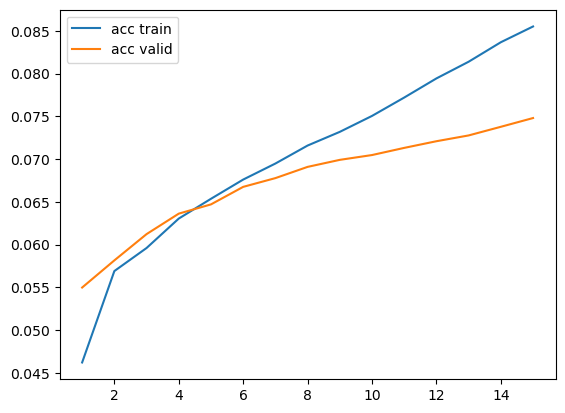

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

epoch_count = range(1, len(history1['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=history1['accuracy'], label='acc train')
sns.lineplot(x=epoch_count,  y=history1['val_accuracy'], label='acc valid')
plt.show()

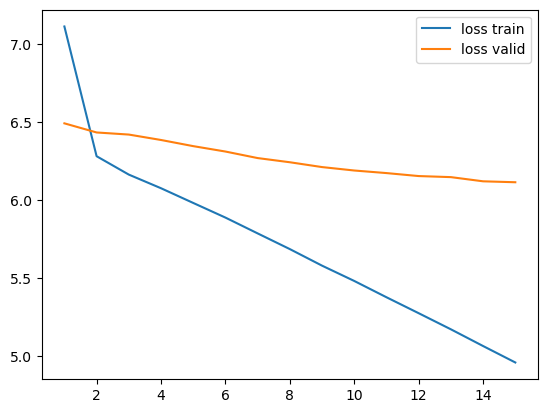

In [37]:
epoch_count = range(1, len(history1['loss']) + 1)
sns.lineplot(x=epoch_count,  y=history1['loss'], label='loss train')
sns.lineplot(x=epoch_count,  y=history1['val_loss'], label='loss valid')
plt.show()

### 5 - Inferencia

Step 1:
A deal is a deal -> Encoder -> enc(h1,c1)

enc(h1,c1) + \<sos> -> Decoder -> Un + dec(h1,c1)

step 2:
dec(h1,c1) + Un -> Decoder -> trato + dec(h2,c2)

step 3:
dec(h2,c2) + trato -> Decoder -> es + dec(h3,c3)

step 4:
dec(h3,c3) + es -> Decoder -> un + dec(h4,c4)

step 5:
dec(h4,c4) + un -> Decoder -> trato + dec(h5,c5)

step 6:
dec(h5,c5) + trato. -> Decoder -> \<eos> + dec(h6,c6)

In [38]:
# Armar los conversores de índice a palabra:
idx2word_input = {v:k for k, v in word2idx_inputs.items()}
idx2word_target = {v:k for k, v in word2idx_outputs.items()}

In [39]:
def prepare_input(input: str):
    print('Input:', input)
    integer_seq = input_tokenizer.texts_to_sequences([input])[0]
    print("Representacion en vector de tokens de ids", integer_seq)
    encoder_sequence = pad_sequences([integer_seq], maxlen=max_input_len)
    print("Padding del vector:", encoder_sequence)
    encoder_sequence_tensor = torch.from_numpy(encoder_sequence.astype(np.int32))
    return encoder_sequence_tensor


In [40]:
input_test = "My mother say hi."
encoder_sequence_test_tensor = prepare_input(input_test)

# Se obtiene la salida del encoder (el estado oculto para el decoder)
prev_state = model.encoder(encoder_sequence_test_tensor.to(device))

# Se inicializa la secuencia de entrada al decoder como "<sos>"
target_seq = np.zeros((1, 1))
target_seq[0, 0] = word2idx_outputs['<sos>']
target_seq_tensor = torch.from_numpy(target_seq.astype(np.int32))

# Se obtiene la primera palabra de la secuencia de salida del decoder
output, prev_state = model.decoder(target_seq_tensor.to(device), prev_state)

top1 = output.argmax(1)
idx = top1.item()
print("Index/token de salida:", idx)

word = idx2word_target[idx]
print("Palabra de salida:", word)

Input: My mother say hi.
Representacion en vector de tokens de ids [16, 231, 134]
Padding del vector: [[  0   0   0   0   0   0   0   0   0   0   0   0   0  16 231 134]]
Index/token de salida: 10
Palabra de salida: es


In [41]:
def translate_sentence(input_seq):
    encoder_sequence_tensor = prepare_input(input_seq)

    # Se transforma la sequencia de entrada a los stados "h" y "c" de la LSTM
    # para enviar la primera vez al decoder"
    prev_state = model.encoder(encoder_sequence_tensor.to(device))

    # Se inicializa la secuencia de entrada al decoder como "<sos>"
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_outputs['<sos>']
    target_seq_tensor = torch.from_numpy(target_seq.astype(np.int32))

    # Se obtiene el indice que finaliza la inferencia
    eos = word2idx_outputs['<eos>']
    
    output_sentence = []
    for _ in range(max_out_len):
        # Predicción del próximo elemento
        output, new_prev_state = model.decoder(target_seq_tensor.to(device), prev_state)
        top1 = output.argmax(1).view(-1, 1)
        idx = int(top1.cpu())

        # Si es "end of sentece <eos>" se acaba
        if eos == idx:
            break

        # Transformar ídx a palabra
        word = ''        
        if idx > 0:
            word = idx2word_target[idx]
            output_sentence.append(word)

        # Actualizar los estados dado la ultimo prediccion
        prev_state = new_prev_state

        # Actualizar secuencia de entrada con la salida (re-alimentacion)
        target_seq_tensor = top1

    return ' '.join(output_sentence)

In [42]:
input_test = "My mother say hi."
translation = translate_sentence(input_test)
print('Response:', translation)

Input: My mother say hi.
Representacion en vector de tokens de ids [16, 231, 134]
Padding del vector: [[  0   0   0   0   0   0   0   0   0   0   0   0   0  16 231 134]]
Response: es de


In [43]:
i = np.random.choice(len(input_sentences))
input = input_sentences[i]
translation = translate_sentence(input)
print('-')
print('Input:', input)
print('Response:', translation)

Input: It is necessary for you to help her.
Representacion en vector de tokens de ids [14, 7, 1034, 20, 4, 2, 99, 41]
Padding del vector: [[   0    0    0    0    0    0    0    0   14    7 1034   20    4    2
    99   41]]
-
Input: It is necessary for you to help her.
Response: que que es de


In [44]:
inputs = ["how you feel", "i'm feeling good", "my friend", "you are crazy", "are you crazy", "that is insane", "let's go home", 
          "A deal is a deal", "rest in peace", "a goal without a plan is just a wish", "never stop learning because life never stops teaching"]
for input in inputs:
    translation = translate_sentence(input)
    print('Response:', translation)
    print('----------')


Input: how you feel
Representacion en vector de tokens de ids [46, 4, 200]
Padding del vector: [[  0   0   0   0   0   0   0   0   0   0   0   0   0  46   4 200]]
Response: te
----------
Input: i'm feeling good
Representacion en vector de tokens de ids [34, 961, 68]
Padding del vector: [[  0   0   0   0   0   0   0   0   0   0   0   0   0  34 961  68]]
Response: no gusta
----------
Input: my friend
Representacion en vector de tokens de ids [16, 209]
Padding del vector: [[  0   0   0   0   0   0   0   0   0   0   0   0   0   0  16 209]]
Response: mi
----------
Input: you are crazy
Representacion en vector de tokens de ids [4, 22, 541]
Padding del vector: [[  0   0   0   0   0   0   0   0   0   0   0   0   0   4  22 541]]
Response: es
----------
Input: are you crazy
Representacion en vector de tokens de ids [22, 4, 541]
Padding del vector: [[  0   0   0   0   0   0   0   0   0   0   0   0   0  22   4 541]]
Response: es
----------
Input: that is insane
Representacion en vector de tokens d

### 6 - Conclusión
A primera vista parece que el modelo tendría que funcionar muy bien por el accuracy alcanzado. La realidad es que las respuestas no tienen que ver demasiado con la pregunta/traducción pero la respuesta en si tiene bastante coherencia.\
Para poder mejorar el modelo haría falta poder consumir todo el dataset y todo el vocabulario, pero la cantidad de RAM no es suficiente.\
Este problema se resuelve con:
- Utilizando un DataGenerator para no levantar todo el dataset junto en el entrenamiento.
- Transfer learning evitando tener que entrenar todo el modelo  